In [5]:
import os
import cv2
import albumentations as A
from tqdm import tqdm

In [ ]:
# Setting Transform for Augmentations
transform = A.Compose([
    A.GaussNoise(var_limit=(10, 50), p=0.5),
    A.Rotate(limit=30, p=0.7),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.6)
])

# Folder function to store augmented images
def augment_folder(input_folder, output_folder, target_count=100):
    os.makedirs(output_folder, exist_ok=True)
    images = [f for f in os.listdir(input_folder) if f.lower().endswith(('.jpg', '.png'))]

    for img_name in tqdm(images, desc=f"Augmenting {input_folder}"):
        img_path = os.path.join(input_folder, img_name)
        image = cv2.imread(img_path)
        base_name = os.path.splitext(img_name)[0]

        # Save original
        cv2.imwrite(os.path.join(output_folder, f"{base_name}_orig.jpg"), image)

        for i in range(target_count - 1):  # Augment until 100 total
            augmented = transform(image=image)["image"]
            cv2.imwrite(os.path.join(output_folder, f"{base_name}_aug{i}.jpg"), augmented)

# Creating the augmented dataset
def augment_dataset(root="Datasets", output="Augmented"):
    for fruit in os.listdir(root):
        fruit_path = os.path.join(root, fruit)
        if not os.path.isdir(fruit_path):
            continue
        for ripeness in os.listdir(fruit_path):
            input_folder = os.path.join(fruit_path, ripeness)
            output_folder = os.path.join(output, fruit, ripeness)
            augment_folder(input_folder, output_folder, target_count=100)

augment_dataset("Datasets", "Augmented")



C:\Users\timne\AppData\Local\Temp\ipykernel_11800\3931299815.py:2: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10, 50), p=0.5),
Augmenting Datasets\Tomato\Unripe: 100%|██████████| 20/20 [00:03<00:00,  6.17it/s]


In [32]:
import os
from torch.utils.data import Dataset
from PIL import Image

class FruitRipenessDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform
        self.class_map = {}  # e.g., {'Banana_Ripe': 0, 'Banana_Unripe': 1, ...}
        class_index = 0

        for class_name in sorted(os.listdir(root_dir)):
            class_folder = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_folder):
                continue

            self.class_map[class_name] = class_index

            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                if img_path.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.image_paths.append(img_path)
                    self.labels.append(class_index)
            class_index += 1

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

In [33]:
import os
import shutil
import random
from tqdm import tqdm

# Split dataset from Augmented into Train/Val/Test (70/20/10)
def split_dataset(input_dir="Augmented", output_dir="FruitData", train_ratio=0.7, val_ratio=0.2, test_ratio=0.1, seed=42):
    random.seed(seed)

    for fruit in os.listdir(input_dir):
        fruit_path = os.path.join(input_dir, fruit)
        if not os.path.isdir(fruit_path):
            continue

        for ripeness in os.listdir(fruit_path):
            class_name = f"{fruit}_{ripeness}"
            class_path = os.path.join(fruit_path, ripeness)

            images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.png'))]
            random.shuffle(images)

            total = len(images)
            train_end = int(train_ratio * total)
            val_end = train_end + int(val_ratio * total)

            splits = {
                "train": images[:train_end],
                "val": images[train_end:val_end],
                "test": images[val_end:]
            }

            for split, split_images in splits.items():
                split_folder = os.path.join(output_dir, split, class_name)
                os.makedirs(split_folder, exist_ok=True)

                for img_name in split_images:
                    src = os.path.join(class_path, img_name)
                    dst = os.path.join(split_folder, img_name)
                    shutil.copy2(src, dst)

    print(f"Dataset split complete and saved to: {output_dir}/train, /val, /test")

split_dataset()



Dataset split complete and saved to: FruitData/train, /val, /test


## Custom Transform for Hue Extraction and Masking

In [35]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt

class HueTransform:
    def __init__(self, resize=(244, 244), hue_range=None, debug=False):
        self.resize = resize
        self.hue_range = hue_range
        self.debug = debug
        self.to_tensor = transforms.ToTensor()

    def __call__(self, img):
        if self.debug:
            plt.imshow(img)
            plt.title("Original RGB")
            plt.axis("off")
            plt.show()

        img = img.convert("HSV")
        hsv = np.array(img)
        hue = hsv[:, :, 0]  # Extract hue channel (0–255)

        if self.hue_range:
            mask = (hue >= self.hue_range[0]) & (hue <= self.hue_range[1])
            hue = np.where(mask, hue, 0)

        # Normalize hue to [0, 1] float range
        hue = hue.astype(np.float32) / 255.0

        # Stack to make it 3-channel (for CNN)
        hue_img = np.stack([hue] * 3, axis=2)

        # Convert to PIL Image and resize
        hue_img = Image.fromarray((hue_img * 255).astype(np.uint8))
        hue_img = hue_img.resize(self.resize)

        if self.debug:
            plt.imshow(hue_img)
            plt.title("Hue Preprocessed")
            plt.axis("off")
            plt.show()


        return self.to_tensor(hue_img)

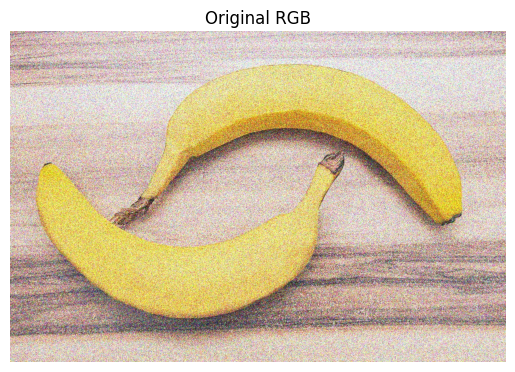

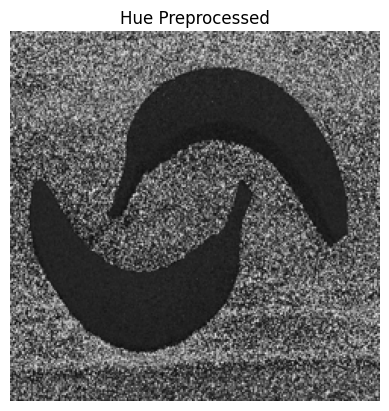

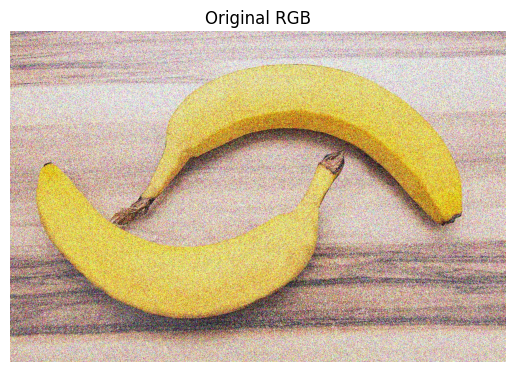

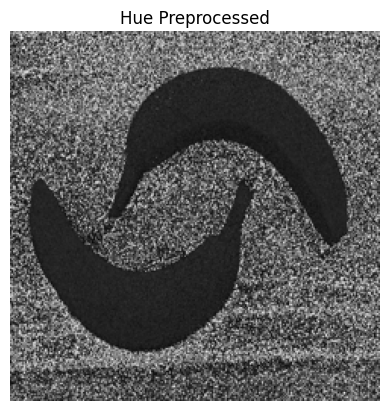

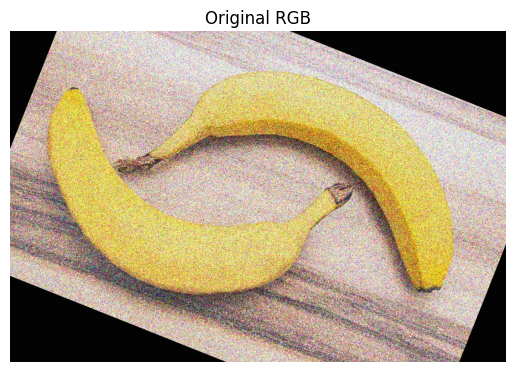

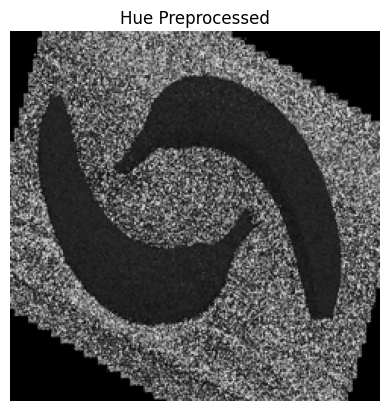

In [36]:
## DEBUG TEST

# Use debug=True just to inspect a few images
debug_transform = HueTransform(resize=(244, 244), hue_range=None, debug=True)

# Check a few training samples
debug_dataset = FruitRipenessDataset(root_dir='FruitData/train', transform=debug_transform)

for i in range(3):  # Only 3 samples
    img, label = debug_dataset[i]

In [37]:
# Apply the custom hue transform
hue_transform = HueTransform(resize=(244, 244), hue_range=None, debug=False)  # Adjust range as needed

# Use ImageFolder with folder name as class label
train_dataset = ImageFolder(root='FruitData/train', transform=hue_transform)
val_dataset = ImageFolder(root='FruitData/val', transform=hue_transform)
test_dataset = ImageFolder(root='FruitData/test', transform=hue_transform)

# Class to index mapping
print(train_dataset.class_to_idx)

{'Banana_Ripe': 0, 'Banana_Unripe': 1, 'Mango_Ripe': 2, 'Mango_Unripe': 3, 'Rambutan_Ripe': 4, 'Rambutan_Unripe': 5, 'Strawberry_Ripe': 6, 'Strawberry_Unripe': 7, 'Tomato_Ripe': 8, 'Tomato_Unripe': 9}


In [38]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Batch shape: torch.Size([32, 3, 244, 244])


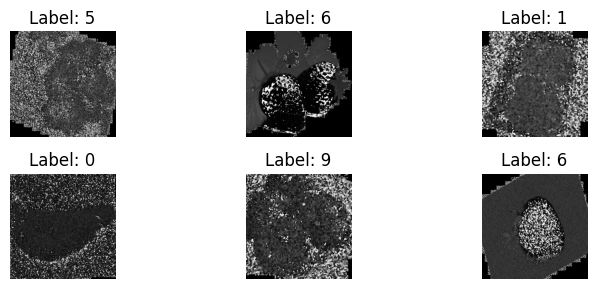

In [39]:
import matplotlib.pyplot as plt

# Check a sample
images, labels = next(iter(train_loader))
print("Batch shape:", images.shape)

# Show a few images
plt.figure(figsize=(8, 3))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    img = images[i].permute(1, 2, 0).numpy()
    plt.imshow(img, cmap='gray')  # grayscale look
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()